# Classification model evaluation

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pyvtorch.aux as vtaux
import timm
import PIL
import pyvdirs.dirs as dirs
from pyvtools.text import find_numbers, filter_by_string_must
from sklearn import metrics

import karras.dnnlib as dnnlib
from karras.training.encoders import PRETRAINED_HOME
import Images.calculate_metrics as calc
import Images.generate_images as gen
import Images.get_validation_metrics as valm
import ours.utils as utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basics

### Load model

In [2]:
model = timm.create_model('swin_large_patch4_window12_384', pretrained=False, drop_path_rate=0.1).cpu()

/home/valeria/anaconda3/envs/SCIDev/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
for param in model.parameters():
    print(param)
    break

Parameter containing:
tensor([[[[ 8.2679e-02, -1.2280e-01, -5.7479e-02, -7.1808e-02],
          [ 9.7300e-02,  8.7680e-02,  8.9033e-02, -6.6988e-02],
          [ 4.8190e-02, -1.3911e-01, -1.2448e-01,  2.0015e-02],
          [-1.3066e-01,  8.5391e-02, -4.1319e-02, -1.3153e-01]],

         [[ 1.0834e-01, -4.7309e-02, -1.3945e-01,  1.1573e-01],
          [ 7.4947e-02,  1.3375e-01, -2.5913e-02, -2.7078e-02],
          [ 1.1793e-04,  4.8424e-02, -1.3401e-02,  6.1336e-02],
          [ 2.1690e-02,  1.2210e-01, -3.6810e-02, -1.3593e-01]],

         [[ 1.3505e-01, -1.1957e-01, -1.3858e-01,  9.3670e-02],
          [-5.4170e-02,  1.9387e-02, -1.3493e-01, -1.1860e-01],
          [-6.8480e-02,  6.3459e-02,  3.6379e-02,  1.3923e-02],
          [-1.2768e-01,  4.7664e-02, -1.0764e-01, -1.3147e-01]]],


        [[[ 1.3559e-01, -1.3441e-01, -1.0511e-01, -3.4443e-02],
          [-9.1734e-02, -1.0385e-01, -5.2376e-02, -1.3879e-01],
          [-9.0539e-02,  1.2469e-01,  9.8418e-02,  8.4556e-02],
          

In [4]:
for param in model.parameters():
    param.requires_grad = False
model.reset_classifier(num_classes=200)

In [5]:
checkpoint = torch.load("/mnt/hdd/vale/models/SCID/Images/00_PreTrained/swin_large_384.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
print(model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
           

### Load dataset

In [7]:
dataset_name = "tiny"

In [8]:
dataset_kwargs = calc.get_dataset_kwargs(dataset_name, image_path=None)
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs, random_seed=0)

In [9]:
dataset_obj.get_details(0)

{'raw_idx': 0,
 'xflip': False,
 'raw_label': 0,
 'name_label': 'n01443537',
 'words_label': 'Goldfish, carassius auratus'}

## Characterize model

### Get classification metrics for the dataset

In [10]:
pil_image = PIL.Image.fromarray(dataset_obj[0][1].swapaxes(0,1).swapaxes(1,2).detach().cpu().numpy().astype(np.uint8), "RGB")

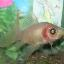

In [11]:
pil_image

In [10]:
29/80

0.3625

In [13]:
n_samples = 100
batch_size = 10
save_period = 1
results = valm.get_classification_metrics("tiny", n_samples, batch_size=batch_size,
                                          save_period=save_period, verbose=True)
top_1_accuracy, top_5_accuracy, confusion_matrix, top_5_correct = results

 10%|█         | 1/10 [00:03<00:35,  3.92s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([ 85,  13,   0, 186, 186, 113,   0,  13, 113,  13])


 20%|██        | 2/10 [00:07<00:30,  3.81s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([ 0, 13,  0, 10, 13, 13,  0,  0, 13, 13])


 30%|███       | 3/10 [00:11<00:26,  3.75s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([13, 13,  0,  0, 13, 41, 13,  0, 89, 13])


 40%|████      | 4/10 [00:15<00:22,  3.73s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([184,   0, 186,   0, 160,   0,   0, 113,   0, 113])


 50%|█████     | 5/10 [00:18<00:18,  3.70s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([ 14,  13,  13,  13,   0,  13, 122,  13, 186,   0])


 60%|██████    | 6/10 [00:22<00:14,  3.67s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([40, 13, 60, 13, 13, 13,  0,  0, 13, 13])


 70%|███████   | 7/10 [00:25<00:11,  3.68s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([  0,  45,  13,  13, 186, 168,   0,  13,  13,   0])


 80%|████████  | 8/10 [00:29<00:07,  3.67s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([ 13, 168, 186, 186,   0,  13,   0,  13, 113,   0])


 90%|█████████ | 9/10 [00:33<00:03,  3.68s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([  0,   0,  13,   0,   0,   0, 186,   0,  13,   0])


100%|██████████| 10/10 [00:36<00:00,  3.69s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([ 13,  13,  13, 113,  13,   0,  13, 122,  13,   0])


Top-1 Accuracy 0.33
Top-5 Accuracy 0.71


### Load results

In [3]:
classification_dir = os.path.join(dirs.DATA_HOME, "class_metrics", "tiny")


In [4]:
contents = os.listdir(classification_dir)

conf_files = filter_by_string_must(contents, "conf")
conf_files.sort()
conf_filepath = os.path.join(classification_dir, conf_files[-1])

topf_files = filter_by_string_must(contents, "topf")
topf_files.sort()
topf_filepath = os.path.join(classification_dir, topf_files[-1])

confusion_matrix = np.load(conf_filepath)
top_5_correct = np.load(topf_filepath)

In [5]:
confusion_matrix

array([[180,   0,   0, ...,   1,   1,   0],
       [  0,  12,   2, ...,   0,   2,   0],
       [  2,   0,  13, ...,   0,   1,   1],
       ...,
       [  3,   0,   0, ...,   0,   2,   0],
       [  9,   0,   0, ...,   0,   2,   0],
       [  6,   0,   0, ...,   0,   1,   0]],
      shape=(200, 200), dtype=uint32)

In [38]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

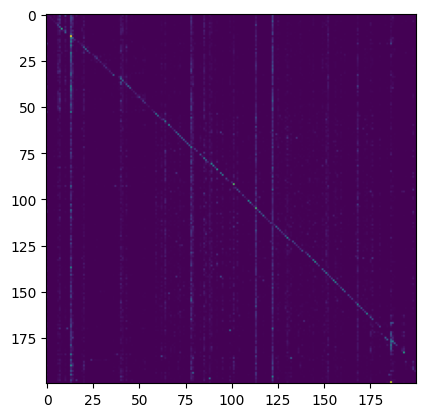

In [8]:
plt.imshow(confusion_matrix/confusion_matrix.max())